In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data=pd.read_csv('/content/drive/MyDrive/2022_Battery_Data/battery-2022-merged.csv')

In [4]:
property_groups = {prop: df for prop, df in data.groupby('Property')}

In [5]:
#
# Group by 'Property' and collect sets of 'Name' values
from collections import defaultdict

property_name_map = defaultdict(set)

for prop, group_df in data.groupby('Property'):
    property_name_map[prop] = set(group_df['Name'])

# Compare sets to find overlaps
from itertools import combinations

shared_names = {}
shared_name_dfs = {}


for (prop1, names1), (prop2, names2) in combinations(property_name_map.items(), 2):
    overlap = names1 & names2
    if overlap:
        shared_names[(prop1, prop2)] = overlap

# Display shared names between property groups
for (prop1, prop2), names in shared_names.items():
  filtered_df = data[
    (data['Property'].isin([prop1, prop2])) &
        (data['Name'].isin(names))
    ]
  shared_name_dfs[(prop1, prop2)] = filtered_df


In [6]:
df = pd.DataFrame(data)

# Group by 'Extracted_name'
g = df.groupby('Extracted_name')

# Create a dictionary to store DataFrames for each Extracted_name with different Property values combined
grouped_dfs = {}

# Loop through each group and combine their rows
for name, group in g:
    # Append all the rows with the same Extracted_name into a single DataFrame
    group = group.drop_duplicates(subset='Property', keep='first')
    grouped_dfs[name] = group  # Store the whole group (with all Property values)



In [7]:
from itertools import combinations
all_data = pd.concat(grouped_dfs.values())

# Get all unique property combinations (pairwise)
unique_properties = all_data['Property'].unique()
property_pairs = combinations(unique_properties, 2)

# Dictionary to store the final dataframes
final_pairwise_dfs = {}

for prop1, prop2 in property_pairs:
    # Filter rows where Property is either prop1 or prop2
    filtered = all_data[all_data['Property'].isin([prop1, prop2])]

    # Group by Extracted_name and keep only those with both properties
    grouped = filtered.groupby('Extracted_name')
    valid_entries = []

    for name, group in grouped:
        if set([prop1, prop2]).issubset(set(group['Property'])):
            # Extract only the two rows and pivot to a single row
            pivoted = group.set_index('Property')['Value'].loc[[prop1, prop2]]
            pivoted_df = pd.DataFrame(pivoted).T
            pivoted_df['Extracted_name'] = name
            valid_entries.append(pivoted_df)

    # Combine all valid entries into one DataFrame
    if valid_entries:
        final_df = pd.concat(valid_entries, ignore_index=True)
        # Reorder columns to have name first
        cols = ['Extracted_name', prop1, prop2]
        final_pairwise_dfs[f"{prop1}-{prop2}"] = final_df[cols]


In [8]:
key_name=[]
key_pop=[]
for key in final_pairwise_dfs.keys():
  key_name.append(str(key))
  key_pop.append(int(final_pairwise_dfs[key].shape[0]))

In [9]:
!pip install jarvis-tools
import jarvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 61.6 MB/s eta 0:00:00


In [ ]:
from jarvis.db.figshare import data
d=data('dft_3d')
didf=pd.DataFrame(d)[['jid','formula']]
g=data('cfid_3d')
oqmd = pd.DataFrame(g)[['jid', 'formula']]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699


100%|██████████| 40.8M/40.8M [00:03<00:00, 13.5MiB/s]


Loading the zipfile...
Loading completed.
Obtaining 3D dataset 55k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699


100%|██████████| 446M/446M [00:20<00:00, 22.2MiB/s]


Loading the zipfile...


In [ ]:
h=data('dft_2d_2021')
dft2_ = pd.DataFrame(h)[['jid', 'formula']]

In [ ]:
j=data('dft_2d')
dft2 = pd.DataFrame(j)[['jid', 'formula']]

In [ ]:
k=data('dft_3d_2021')
dft3d = pd.DataFrame(k)[['jid', 'formula']]

In [ ]:
l=data('jff')
jff = pd.DataFrame(l)[['jid', 'formula']]
m=data('qe_tb')
qetb=pd.DataFrame(m)[['jid','formula']]

In [ ]:
#creating dataframes for all types of data
capacity = property_groups['Capacity']
voltage=property_groups['Voltage']
energy=property_groups['Energy']
columbic=property_groups['Coulombic Efficiency']
conductivity=property_groups['Conductivity']



In [ ]:
import pandas as pd
import re
from fractions import Fraction
import ast

# Pre-index all dataframes
for df in [oqmd, dft2, dft2_, dft3d, jff, qetb, didf]:
    if 'formula' in df.columns:
        df['formula'] = df['formula'].astype(str)
        df.set_index('formula', inplace=True, drop=False)

# Combine all formula→jid mappings into one dictionary
formula_to_jid = {}

for df in [oqmd, dft2, dft2_, dft3d, jff, qetb, didf]:
    if 'formula' in df.columns and 'jid' in df.columns:
        formula_to_jid.update(df[['formula', 'jid']].dropna().set_index('formula')['jid'].to_dict())

def gcd(a, b):
    while b:
        a, b = b, a % b
    return a

def normalize_formula(formula):
    tokens = re.findall(r'([A-Z][a-z]*)(\d*)', formula)
    tokens = sorted([(el, int(cnt) if cnt else 1) for el, cnt in tokens])
    return ''.join([f"{el}{cnt if cnt > 1 else ''}" for el, cnt in tokens])

def generate_empirical_formula_from_dict(element_dict):
    try:
        element_dict = {k: float(v) for k, v in element_dict.items()}
        fractions = [Fraction(v).limit_denominator() for v in element_dict.values()]
        denominators = [f.denominator for f in fractions]

        lcm = 1
        for d in denominators:
            lcm = lcm * d // gcd(lcm, d)

        formula = ''
        for elem, val in element_dict.items():
            num = int(round(val * lcm))
            formula += f"{elem}{num if num > 1 else ''}"

        return normalize_formula(formula)
    except:
        return 'Non-standard'

def get_jid_fast(formula):
    """Fast lookup from pre-computed formula_to_jid dict, includes normalized fallback."""
    if not formula or not isinstance(formula, str):
        return "Invalid input"
    jid = formula_to_jid.get(formula)
    if jid:
        return jid
    normalized = normalize_formula(formula)
    return formula_to_jid.get(normalized, f"No JID found for formula '{formula}'")

def JID_to_csv(df, excel_name):
    formulas = []
    for item in df['Extracted_name']:
        try:
            formula_list = ast.literal_eval(item)
            formula_dict = formula_list[0]  # First dict in list
            formula = generate_empirical_formula_from_dict(formula_dict)
        except Exception as e:
            formula = 'Non-standard'
        formulas.append(formula)

    # Generate dataframe
    formulas_df = pd.DataFrame({'Formula': formulas})
    mask_valid = formulas_df['Formula'] != 'Non-standard'
    formulas_df.loc[mask_valid, 'jid'] = formulas_df.loc[mask_valid, 'Formula'].map(get_jid_fast)

    # Combine with original DataFrame
    df = df.reset_index(drop=True)
    formulas_df = formulas_df.reset_index(drop=True)
    df['Formula'] = formulas_df['Formula']
    df['jid'] = formulas_df['jid']

    # Write to Excel
    df.to_excel(f'/content/drive/MyDrive/2022_Battery_Data/{excel_name}.xlsx', index=False)


In [ ]:
JID_to_csv(voltage,'voltage')
JID_to_csv(capacity,'capacity')
JID_to_csv(energy,'energy')
JID_to_csv(columbic,'columbic Efficiency')
JID_to_csv(conductivity,'conductivity')

In [3]:
path='/content/drive/MyDrive/2022_Battery_Data/'

In [ ]:
#visualization of data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# List of target properties
target_property_list = ['voltage', 'energy', 'conductivity', 'columbic Efficiency']

# Set up subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()  # Flatten to easily index

# Loop through each property and plot
for i, target_property in enumerate(target_property_list):
    # Load dataset
    df1 = pd.read_excel(f'{path}{target_property}.xlsx')

    # Compute average Value per 'jid'
    avg_df = df1.groupby('jid')['Value'].mean().reset_index()

    # Filter 'jid's that start with 'JVASP'
    avg_df = avg_df[avg_df['jid'].astype(str).str.startswith('JVASP')]

    # Plot distribution
    ax = axes[i]
    sns.histplot(avg_df['Value'], kde=True, ax=ax, bins=30, color='skyblue', edgecolor='black')
    ax.set_title(f"{target_property.capitalize()} (n={len(avg_df)})")
    ax.set_xlabel("Value of Property")
    ax.set_ylabel("Frequency")

# Adjust layout
plt.tight_layout()
plt.savefig(f'{path}populations.png',dpi=300)
plt.show()


In [5]:

# Initialize R^2 score dictionary
r2_scores = {
    "Linear Regression": [],
    "MLP Regressor": [],
    "Random Forest Regressor": [],
    "KNN Regressor": [],
    "Decision Tree Regressor": []
}

mae_scores = {
    "Linear Regression": [],
    "MLP Regressor": [],
    "Random Forest Regressor": [],
    "KNN Regressor": [],
    "Decision Tree Regressor": []
}

valid_target_properties = []

In [6]:
# target_property_list = ['voltage', 'energy', 'conductivity', 'columbic_efficiency']
target_property_list = ['voltage', 'energy', 'conductivity','columbic Efficiency']

In [6]:
gnn_data = pd.read_csv(f'{path}data0.csv')

## Train Models

In [8]:
## K means evaluation (k=10)

kf = KFold(n_splits=10, shuffle=False)

for target_property in target_property_list:
    print(f"STARTING PROPERTY {target_property.upper()}")
    try:
        df1 = pd.read_excel(f'{path}{target_property}.xlsx')
    except Exception as e:
        print(f"Failed to load data for {target_property}: {e}")
        continue

    avg_df = df1.groupby('jid')['Value'].mean().reset_index()
    avg_df = avg_df[avg_df['jid'].astype(str).str.startswith('JVASP')]

    merged_df = pd.merge(avg_df, gnn_data, left_on='jid', right_on='id')
    merged_df = merged_df[merged_df['jid'] == merged_df['id']].dropna()

    # Ensure enough data
    if merged_df.shape[0] < 10:
        print(f"Skipping {target_property} due to insufficient data ({merged_df.shape[0]} rows).")
        continue

    # Extract features and target
    X = merged_df.drop(columns=['Value', 'id', 'jid'])
    X = X.select_dtypes(include=[np.number])  # only numeric features
    y = merged_df['Value'].values

    if X.shape[0] != len(y):
        print(f"Skipping {target_property} due to X/y shape mismatch.")
        continue

    # Normalize features for MLP/KNN
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Store valid target property for plotting
    valid_target_properties.append(target_property)

    # Train and evaluate models
    models = {
        "Linear Regression": LinearRegression(),
        "MLP Regressor": MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=10000, random_state=42),
        "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
        "KNN Regressor": KNeighborsRegressor(n_neighbors=5),
        "Decision Tree Regressor": DecisionTreeRegressor(random_state=42)
    }

    for name, model in models.items():
        print(f"Starting model {name}")
        fold_r2_accuracies = []
        fold_mae_accuracies = []

        for fold, (train_index, test_index) in enumerate(kf.split(X)):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]


            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)
            fold_r2_accuracies.append(r2)

            mae = mean_absolute_error(y_test, y_pred)
            fold_mae_accuracies.append(mae)

            # print(f"Completed fold {fold} with MAE {mae}")

        mae_scores[name].append(np.average(fold_mae_accuracies))
        r2_scores[name].append(np.average(fold_r2_accuracies))

        print(f"Finished property {name} with average MAE {np.average(fold_mae_accuracies)}")


STARTING PROPERTY VOLTAGE
Starting model Linear Regression
Finished property Linear Regression with average MAE 1.2491237396220771
Starting model MLP Regressor
Finished property MLP Regressor with average MAE 0.6629912777498144
Starting model Random Forest Regressor
Finished property Random Forest Regressor with average MAE 0.5968341164955335
Starting model KNN Regressor
Finished property KNN Regressor with average MAE 0.6163696614374593
Starting model Decision Tree Regressor
Finished property Decision Tree Regressor with average MAE 0.8485170375694912
STARTING PROPERTY ENERGY
Starting model Linear Regression
Finished property Linear Regression with average MAE 805.847268183589
Starting model MLP Regressor
Finished property MLP Regressor with average MAE 536.7420384831004
Starting model Random Forest Regressor
Finished property Random Forest Regressor with average MAE 477.569366955862
Starting model KNN Regressor
Finished property KNN Regressor with average MAE 444.8142000810045
Starti

In [8]:
valid_target_properties=['Voltage','Energy','Conductivity','Columbic Efficiency']

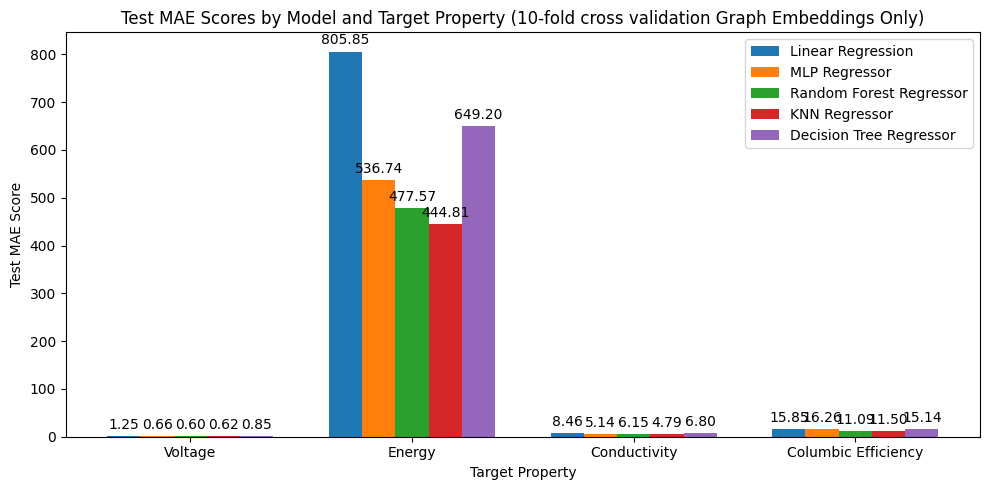

In [10]:
plt.rcParams.update({'font.size': 10})
x = np.arange(len(valid_target_properties))
width = 0.15
fig, ax = plt.subplots(figsize=(10, 5))

def split_scores(scores):
    """Return (valid_scores, invalid_flags)"""
    visible = [v if v >= 0 else 0 for v in scores]
    invalid_flags = [v < 0 for v in scores]
    return visible, invalid_flags

def plot_model(ax, offset, scores, label, color):
    visible, is_invalid = split_scores(scores)
    rects_visible = ax.bar(x + offset, visible, width, label=label, color=color)

    # Draw hatched rectangles for invalid scores at fixed height
    hatch_height = 0.05  # fixed height for placeholder
    for i, invalid in enumerate(is_invalid):
        if invalid:
            ax.bar(x[i] + offset, hatch_height, width,
                   fill=False, hatch='//', edgecolor=color, linewidth=1)

    return rects_visible

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

rects1 = plot_model(ax, -2*width, mae_scores["Linear Regression"][-4:], 'Linear Regression', colors[0])
rects2 = plot_model(ax, -width, mae_scores["MLP Regressor"][-4:], 'MLP Regressor', colors[1])
rects3 = plot_model(ax, 0, mae_scores["Random Forest Regressor"][-4:], 'Random Forest Regressor', colors[2])
rects4 = plot_model(ax, width, mae_scores["KNN Regressor"][-4:], 'KNN Regressor', colors[3])
rects5 = plot_model(ax, 2*width, mae_scores["Decision Tree Regressor"][-4:], 'Decision Tree Regressor', colors[4])

# Format axes
ax.set_xlabel('Target Property')
ax.set_ylabel('Test MAE Score')
ax.set_title('Test MAE Scores by Model and Target Property (10-fold cross validation Graph Embeddings Only)')
ax.set_xticks(x)
ax.set_xticklabels([prop.title() for prop in target_property_list], rotation=0, ha='center')
ax.legend()
# ax.set_ylim(0, 0.8)  # Set max height to 0.8

# Annotate only positive R² values
def add_annotations(rects):
    for rect in rects:
        height = rect.get_height()
        if height >= 0.01:
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

for rect_set in [rects1, rects2, rects3, rects4, rects5]:
    add_annotations(rect_set)

fig.tight_layout()
plt.show()

[0 1 2 3] -0.3 [np.float64(1.2491237396220771)] 0.15 Linear Regression tab:blue
<BarContainer object of 1 artists>
[0 1 2 3] -0.15 [np.float64(0.6629912777498144)] 0.15 MLP Regressor tab:orange
<BarContainer object of 1 artists>
[0 1 2 3] 0 [np.float64(0.5968341164955335)] 0.15 Random Forest Regressor tab:green
<BarContainer object of 1 artists>
[0 1 2 3] 0.15 [np.float64(0.6163696614374593)] 0.15 KNN Regressor tab:red
<BarContainer object of 1 artists>
[0 1 2 3] 0.3 [np.float64(0.8485170375694912)] 0.15 Decision Tree Regressor tab:purple
<BarContainer object of 1 artists>


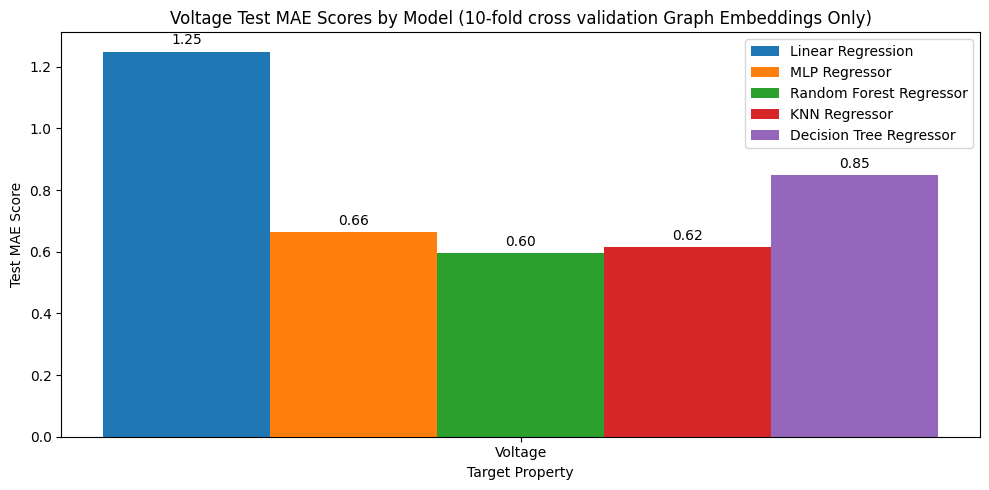

In [11]:
plt.rcParams.update({'font.size': 10})
x = np.arange(len(valid_target_properties))
width = 0.15
fig, ax = plt.subplots(figsize=(10, 5))

def split_scores(scores):
    """Return (valid_scores, invalid_flags)"""
    visible = [v if v >= 0 else 0 for v in scores]
    invalid_flags = [v < 0 for v in scores]
    return visible, invalid_flags

def plot_model(ax, offset, scores, label, color):
    visible, is_invalid = split_scores([scores[0]])
    rects_visible = ax.bar(x[0] + offset, visible, width, label=label, color=color)
    print(x, offset, visible, width, label, color)
    print(rects_visible)

    # Draw hatched rectangles for invalid scores at fixed height
    # hatch_height = 0.05  # fixed height for placeholder
    # for i, invalid in enumerate(is_invalid):
    #     if invalid:
    #         ax.bar(x[i] + offset, hatch_height, width,
    #                fill=False, hatch='//', edgecolor=color, linewidth=1)

    return rects_visible

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

rects1 = plot_model(ax, -2*width, mae_scores["Linear Regression"][-4:], 'Linear Regression', colors[0])
rects2 = plot_model(ax, -width, mae_scores["MLP Regressor"][-4:], 'MLP Regressor', colors[1])
rects3 = plot_model(ax, 0, mae_scores["Random Forest Regressor"][-4:], 'Random Forest Regressor', colors[2])
rects4 = plot_model(ax, width, mae_scores["KNN Regressor"][-4:], 'KNN Regressor', colors[3])
rects5 = plot_model(ax, 2*width, mae_scores["Decision Tree Regressor"][-4:], 'Decision Tree Regressor', colors[4])

# Format axes
ax.set_xlabel('Target Property')
ax.set_ylabel('Test MAE Score')
ax.set_title('Voltage Test MAE Scores by Model (10-fold cross validation Graph Embeddings Only)')
ax.set_xticks([0])

ax.set_xticklabels(['Voltage'], rotation=0, ha='center')
ax.legend()
# ax.set_ylim(0, 0.8)  # Set max height to 0.8

# Annotate only positive R² values
def add_annotations(rects):
    for rect in rects:
        height = rect.get_height()
        if height >= 0.01:
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

for rect_set in [rects1, rects2, rects3, rects4, rects5]:
    add_annotations(rect_set)

fig.tight_layout()
plt.show()

In [9]:
## K means evaluation (k=10)

kf = KFold(n_splits=10, shuffle=False)

target_property = "voltage"
df1 = pd.read_excel(f'{path}{target_property}.xlsx')

avg_df = df1.groupby('jid')['Value'].mean().reset_index()
avg_df = avg_df[avg_df['jid'].astype(str).str.startswith('JVASP')]

merged_df = pd.merge(avg_df, gnn_data, left_on='jid', right_on='id')
merged_df = merged_df[merged_df['jid'] == merged_df['id']].dropna()


# Extract features and target
X = merged_df.drop(columns=['Value', 'id', 'jid'])
X = X.select_dtypes(include=[np.number])  # only numeric features
y = merged_df['Value'].values


# Normalize features for MLP/KNN
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Store valid target property for plotting
valid_target_properties.append(target_property)


In [10]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'criterion': ['absolute_error']
}
# === RandomizedSearchCV to find best params ===
search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=42,
    n_jobs=-1,
    error_score='raise'
)
search.fit(X, y)
best_params = search.best_params_
print("Best Parameters:", best_params)

# === Cross-validation using best model ===
best_model = RandomForestRegressor(**best_params, random_state=42)

fold_mae_accuracies = []
fold_r2_accuracies = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    fold_mae_accuracies.append(mae)
    fold_r2_accuracies.append(r2)


Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'absolute_error', 'bootstrap': False}


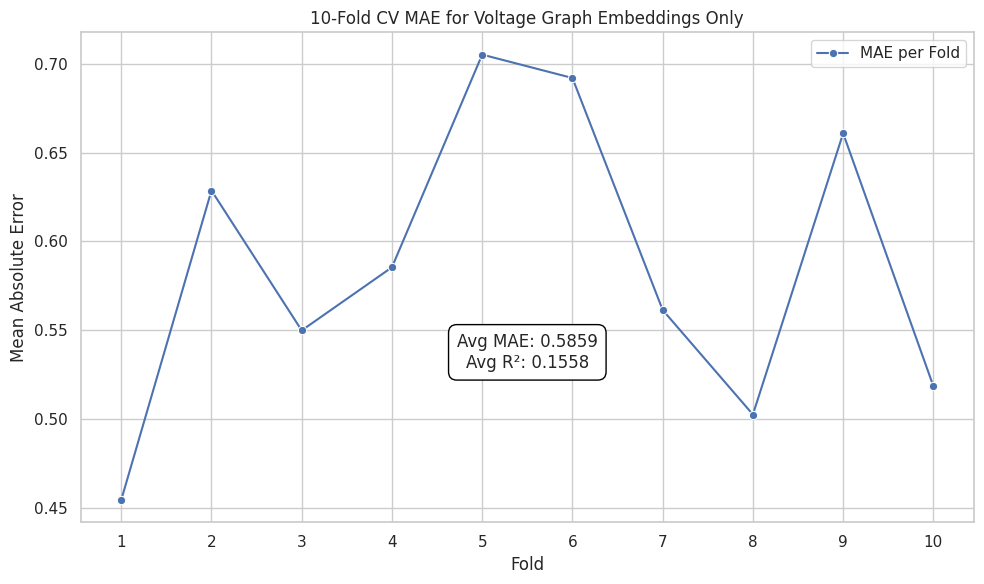

In [11]:
import seaborn as sns
# === Plot MAE per fold ===
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, 11), y=fold_mae_accuracies, marker='o', label='MAE per Fold')
plt.title(f"10-Fold CV MAE for Voltage Graph Embeddings Only")
plt.xlabel("Fold")
plt.ylabel("Mean Absolute Error")
plt.xticks(range(1, 11))

# === Add result box without using patches ===
box_text = f"Avg MAE: {np.mean(fold_mae_accuracies):.4f}\nAvg R²: {np.mean(fold_r2_accuracies):.4f}"
xpos = 5.5
ypos = max(fold_mae_accuracies) * 0.75
plt.text(
    xpos, ypos, box_text,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'),
    ha='center'
)

plt.legend()
plt.tight_layout()
plt.show()

In [12]:
best_params

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 10,
 'criterion': 'absolute_error',
 'bootstrap': False}

In [13]:
fold_mae_accuracies

[0.4544162537179927,
 0.6286249486466414,
 0.5498582141008969,
 0.5854141451252363,
 0.7051405604255104,
 0.6919620634962967,
 0.5613763897379286,
 0.5025233293600772,
 0.6608343039896635,
 0.5184637199332756]

In [14]:
from sklearn.model_selection import cross_val_score
results = search.cv_results_
results_df = pd.DataFrame(results, columns=['params', 'mean_test_score'])

# Convert to positive MAE
results_df.rename(columns={'mean_test_score': 'mean_score'}, inplace=True)
results_df['mean_score'] = -results_df['mean_score']  # Convert from negative MAE to actual MAE

# Flatten the params dictionary for visualization
params_df = pd.json_normalize(results_df['params'])
results_df = pd.concat([results_df.drop('params', axis=1), params_df], axis=1)

In [15]:
results_df

,mean_score,n_estimators,min_samples_split,min_samples_leaf,max_features,max_depth,criterion,bootstrap
0,0.606565,200,5,1,sqrt,30.0,absolute_error,True
1,0.590028,200,5,4,sqrt,30.0,absolute_error,False
2,0.612922,500,2,2,None,20.0,absolute_error,True
3,0.590744,500,2,4,log2,30.0,absolute_error,True
4,0.588829,200,10,4,log2,10.0,absolute_error,False
5,0.821082,200,5,2,None,50.0,absolute_error,False
6,0.601265,100,2,2,log2,20.0,absolute_error,True
7,0.598714,500,2,1,log2,20.0,absolute_error,False
8,0.616779,200,5,4,None,30.0,absolute_error,True
9,0.598732,500,2,1,sqrt,20.0,absolute_error,False


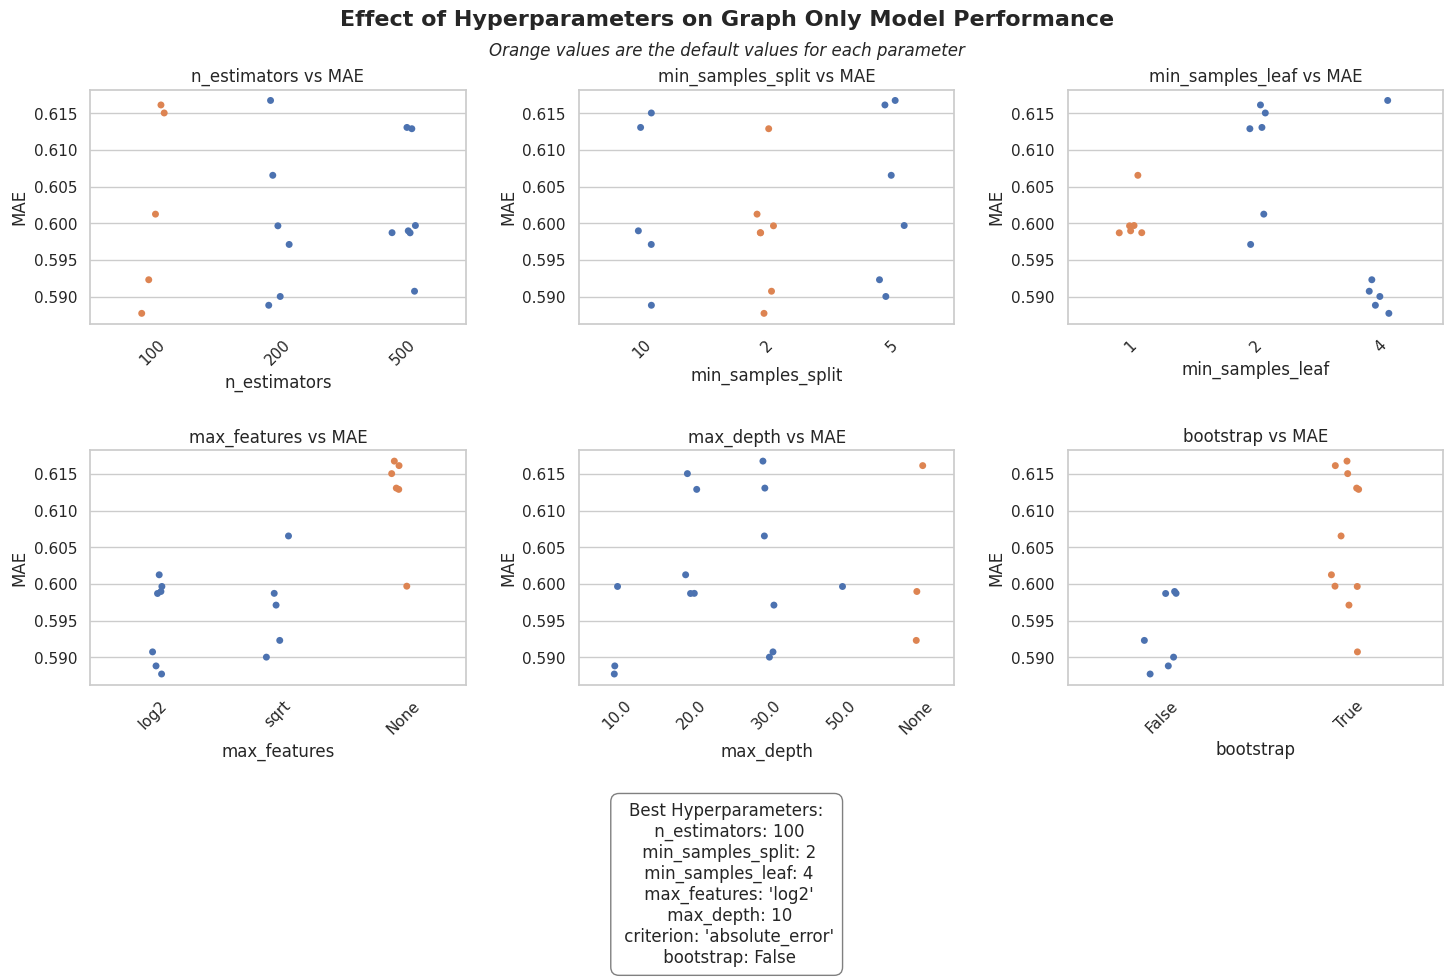

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get the default features
default_model = RandomForestRegressor()
defaults = default_model.get_params()
defaults['max_features'] = 'None'

# Filter out outliers with high MAEs for clear visualization
filtered_df = results_df[results_df['mean_score'] <= 0.75].copy()

# Drop only the score column; include all params
param_columns = [col for col in results_df.columns if col != "mean_score" and col != "criterion"]

# Convert all param columns to string for consistent plotting
plot_df = filtered_df.copy()
for col in param_columns:
    plot_df[col] = plot_df[col].astype(str).replace("nan", "None")

# Set up subplot grid
n_cols = 3
n_rows = (len(param_columns) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

# Plot each parameter vs. mean_score
for i, param in enumerate(param_columns):

    default_value = str(defaults[param])
    plot_df['is_default'] = plot_df[param] == default_value

    ordering = sorted(plot_df[param].unique(), key=lambda x: (x == "nan" or x == "None", x)) # put the nan values at the end
    sns.stripplot(data=plot_df, x=param, y='mean_score', ax=axes[i], order=ordering, jitter=True, hue='is_default', legend=False)
    axes[i].set_title(f"{param} vs MAE")
    # axes[i].set_xlabel(param)
    axes[i].set_ylabel("MAE")
    axes[i].tick_params(axis='x', rotation=45)

fig.suptitle("Effect of Hyperparameters on Graph Only Model Performance", fontsize=16, fontweight='bold')
fig.text(0.5, 0.94, "Orange values are the default values for each parameter", ha='center', va='top', fontsize=12, style='italic')
# Format best_params nicely as a string
best_params_str = "\n".join(
    f" {k}: {repr(v)}" for k, v in search.best_params_.items()
)

# Add a textbox at the bottom center
fig.text(
    0.5, -0.01, f"Best Hyperparameters:\n{best_params_str}",
    ha='center', va='top', fontsize=12, bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="gray")
)
plt.tight_layout(pad=2.0)
plt.subplots_adjust(top=0.88)
plt.show()

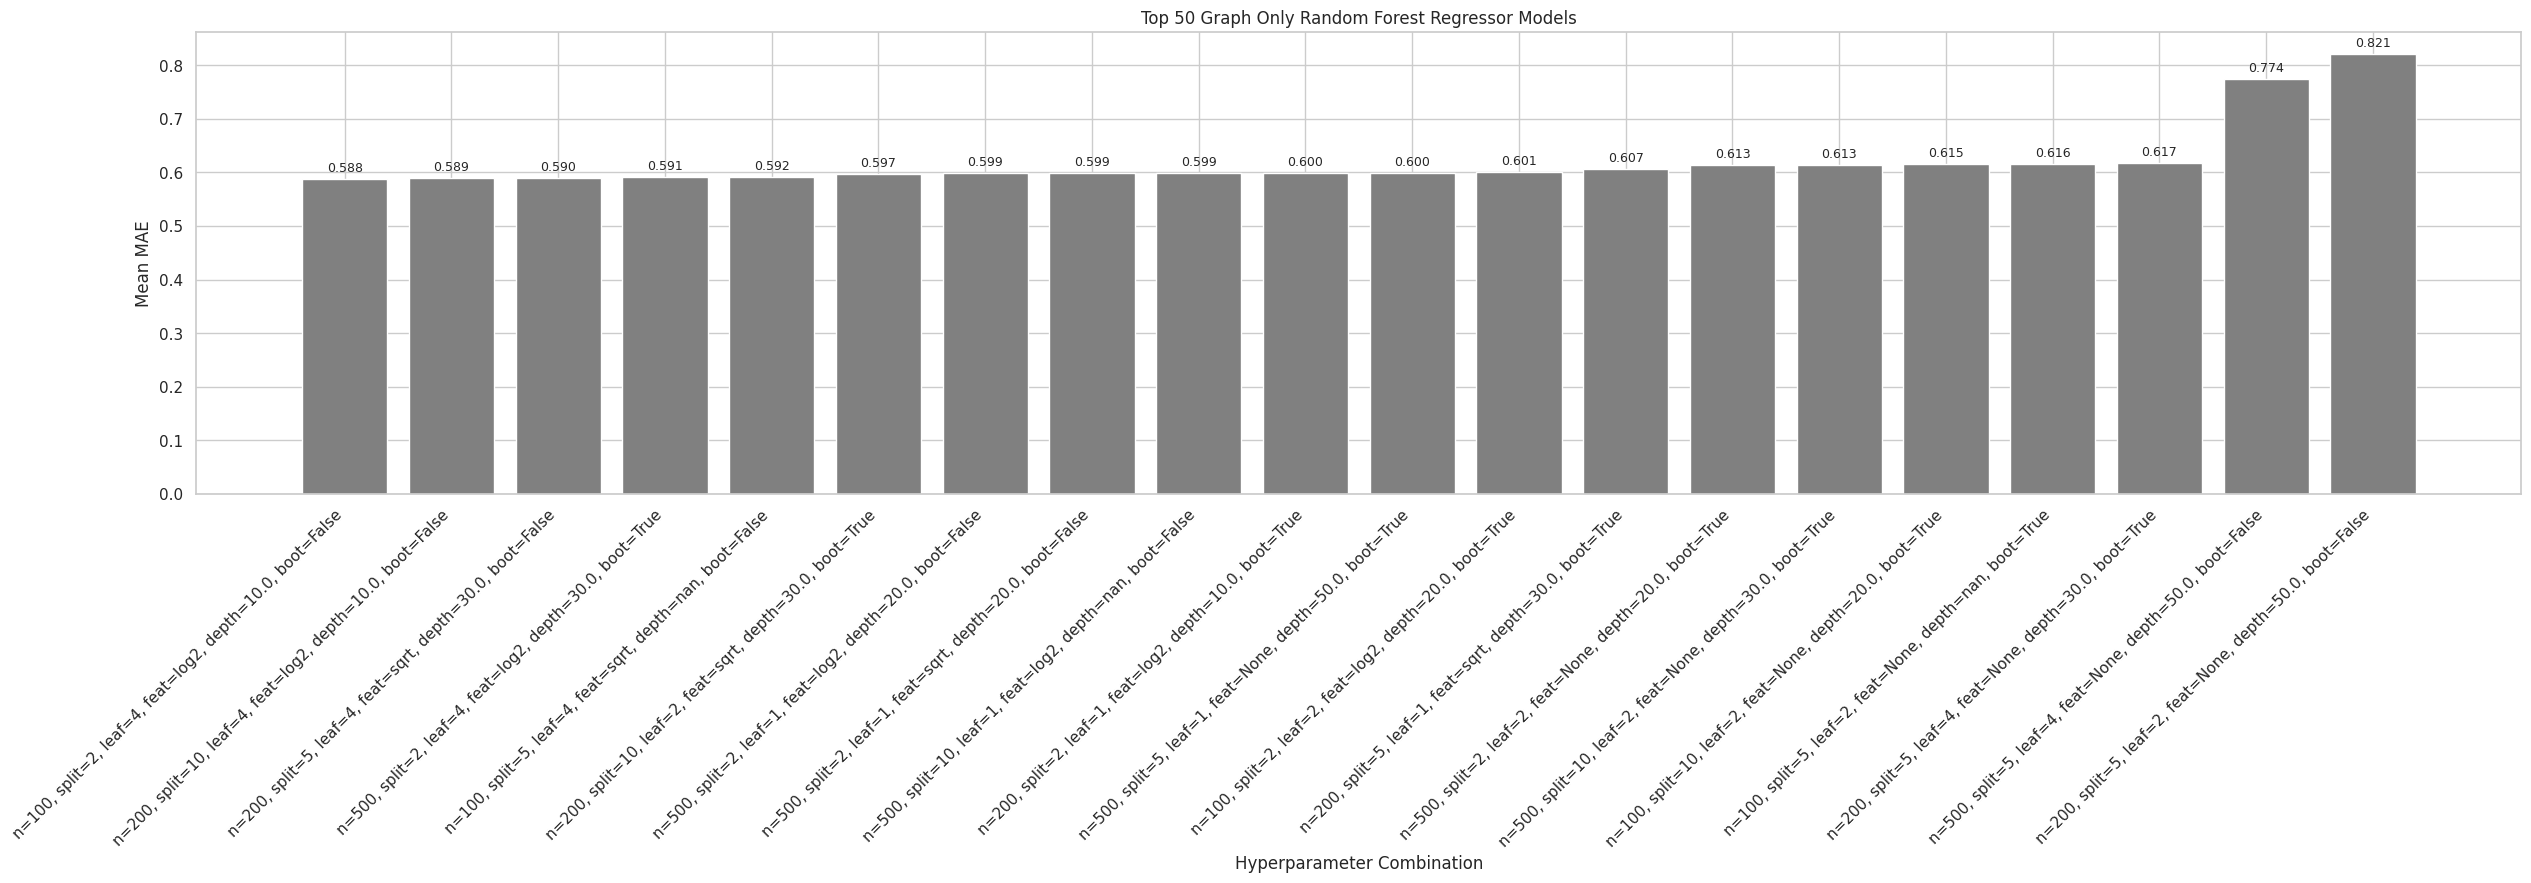

In [20]:
import matplotlib.pyplot as plt



# Sort and select top N models
top_n = 50
plot_df = results_df.sort_values("mean_score").head(top_n).copy()

# Create readable labels
plot_df["params_str"] = plot_df.apply(
    lambda row: f"n={row.n_estimators}, split={row.min_samples_split}, leaf={row.min_samples_leaf}, feat={row.max_features}, depth={row.max_depth}, boot={row.bootstrap}",
    axis=1
)

# Plot
fig, ax = plt.subplots(figsize=(30, 6))
bars = ax.bar(plot_df["params_str"], plot_df["mean_score"], color="gray")

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01 * max(plot_df["mean_score"]),
        f"{height:.3f}",
        ha='center',
        va='bottom',
        fontsize=9
    )

# Labels and layout
ax.set_ylabel("Mean MAE")
ax.set_xlabel("Hyperparameter Combination")
ax.set_title(f"Top {top_n} Graph Only Random Forest Regressor Models")
plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
plt.show()